In [99]:
import xarray as xr
import pandas as pd
import numpy as np
import intake

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
import seaborn as sns

from datetime import datetime

from dask.diagnostics import ProgressBar

In [48]:
import iris
import iris.analysis as ia

In [51]:
def ifs_to_latlon(ds):
    '''
    Uses the latitude-longitude information encoded in the regular grid IFS output to reconstructed the regular grid
    '''
    return ds.rename({'value':'latlon'}).set_index(latlon=("lat","lon")).unstack("latlon")
def ifs_fix_time_for_monthly_data(ds):
    '''
    Monthly mean data has the time axis encoded incorrectly.
    This function shifts it back by one day
    '''
    return ds.assign_coords(time=ds['time']- pd.Timedelta('1D'))

def get_area(da,mask=False):
    print('Computing grid-box area')
    import iris.analysis as ia
    if 'time' in da.dims:
        da = da.isel(time=0).drop('time')
    d = da.to_iris()
    d.coord('longitude').guess_bounds()
    d.coord('latitude').guess_bounds()

    area_weights = ia.cartography.area_weights(d)
    area = xr.ones_like(da) * area_weights
    if mask:
        area = area.where(~np.isnan(da))
    area = area.rename('area').load()
    area.attrs['long_name'] = 'grid_box_area'
    area.attrs['units'] = 'm^2'
    return area

def print_var(ds,filt=None):
    '''
    Print variables (varname,name) in Dataset. 
    If <filt> is provided, print only those where <filt> is present in the <name> attribute (ds[shortname].attrs['name'])

    Usage: print_var(ds,'wind')
    Output: printout of variables in ds whose name (long name in attributes, not short name to access) contains 'wind', e.g.
        10si  :   10 metre wind speed
        10u  :   10 metre U wind component
        10v  :   10 metre V wind component
    '''
    if filt:
        [print('%10s  :   %s' % (d,ds[d].attrs['name'])) for d in ds if filt.lower() in ds[d].attrs['name'].lower()]
    else:
        [print('%10s  :   %s' % (d,ds[d].attrs['name'])) for d in ds]

## Open and inspect the catalogue

In [5]:
cat = intake.open_catalog('https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml')\
                          ['dkrz']['disk']['model-output']['ifs-amip']

In [6]:
list(cat)

['amip-hist-obs.atmos.gr025',
 'amip-hist-obs-lr30.atmos.gr025',
 'amip-ng-obs.atmos.gr025',
 'amip-ng-obs-lr30.atmos.gr025']

In [7]:
list(cat['amip-hist-obs.atmos.gr025'])

['2D_const_0.25deg',
 '2D_6h_0.25deg',
 '2D_24h_0.25deg',
 '2D_monthly_0.25deg',
 '3D_6h_0.25deg',
 '3D_24h_0.25deg',
 '3D_monthly_0.25deg']

## Load the data to dask (lazy!)

In [30]:
ds = cat['amip-hist-obs.atmos.gr025']['2D_monthly_0.25deg'].to_dask()
# The following is necessary for MONTHLY data, NOT step data!
ds = ifs_fix_time_for_monthly_data(ds)

In [31]:
ds

<xarray.Dataset>
Dimensions:  (time: 132, value: 1038240)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(1038240,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(1038240,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2010-01-31 2010-02-28 ... 2020-12-31
Dimensions without coordinates: value
Data variables: (12/50)
    10si     (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    10u      (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    10v      (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    2d       (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    2t       (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    cape     (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    ...       ...
    swvl4    (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    tcc      (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    tciw     (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    tclw     (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    tcwv     (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    tprate   (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
Attributes:
    edition:            1
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

In [32]:
ds = ifs_to_latlon(ds)

In [33]:
ds

<xarray.Dataset>
Dimensions:  (lat: 721, lon: 1440, time: 132)
Coordinates:
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * time     (time) datetime64[ns] 2010-01-31 2010-02-28 ... 2020-12-31
Data variables: (12/50)
    10si     (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10u      (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10v      (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2d       (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2t       (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    cape     (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    ...       ...
    swvl4    (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    tcc      (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    tciw     (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    tclw     (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    tcwv     (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    tprate   (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    edition:            1
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

In [52]:
# compute grid-box area
area = get_area(ds.sst)

Computing grid-box area


/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


## Simple plot

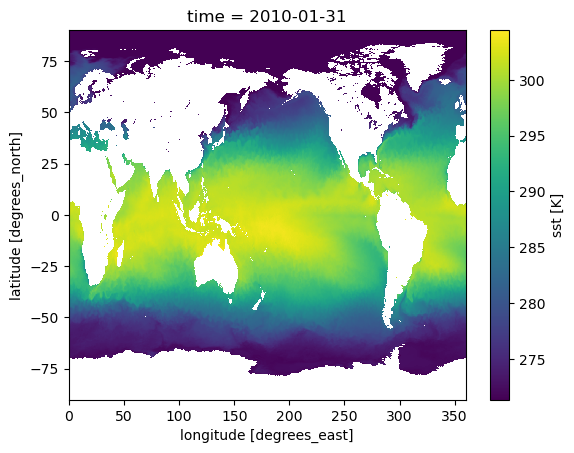

In [34]:
ds.sst.isel(time=0).plot()

Text(0.5, 1.0, 'Monthly mean SST for January 2010')

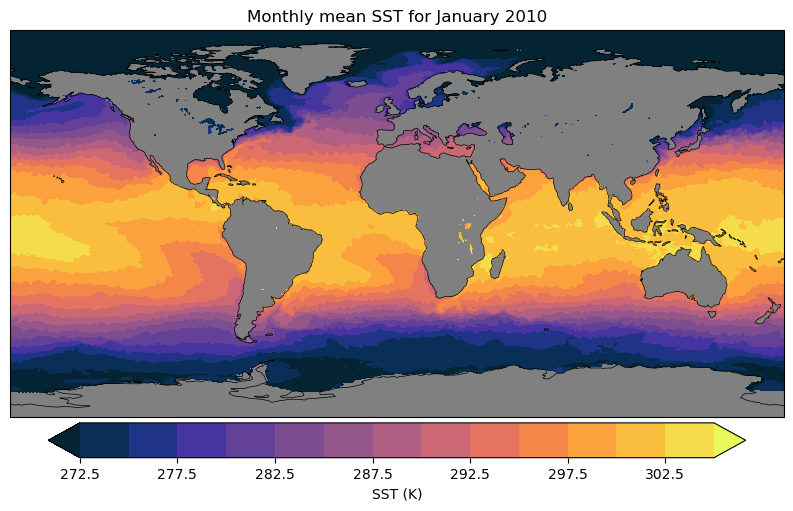

In [46]:
ff = ds.sst.isel(time=0).plot.contourf(
    levels=np.arange(270+2.5,305+2.5,2.5),
    extend='both',
    cmap=cmo.thermal,
    subplot_kws=dict(
        projection=ccrs.PlateCarree()
    ),
    cbar_kwargs=dict(
        orientation='horizontal',
        shrink=0.9,
        pad=0.0125,
        label='SST (K)',
        extend='both'
    ),
    transform=ccrs.PlateCarree(),
    figsize=(10,6)
)

ff.axes.set_facecolor('grey')
ff.axes.coastlines(lw=0.5)
ff.axes.set_title('Monthly mean SST for January 2010')

## area-weighted global mean monthly sea surface and surface air temperature

(14610.0, 18627.0)

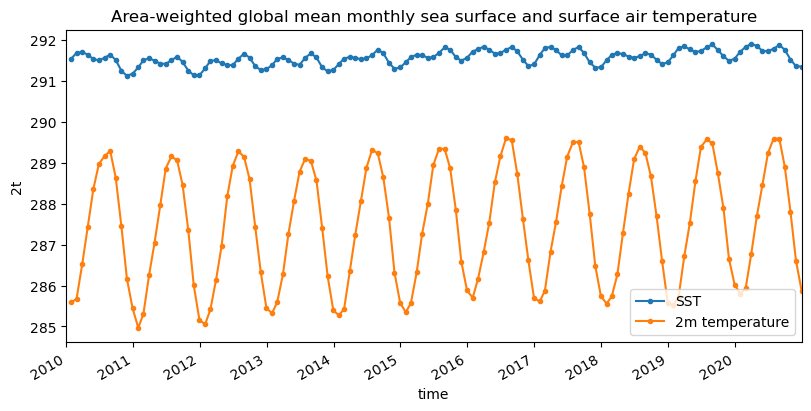

In [69]:
fig, ax = plt.subplots(figsize=(8,4),constrained_layout=True)

ds['sst'].weighted(area).mean(['lat','lon']).plot.line(
 '.-',label='SST',ax=ax)
ds['2t'].weighted(area).mean(['lat','lon']).plot.line(
 '.-',label='2m temperature',ax=ax)

ax.legend()
ax.set_title("Area-weighted global mean monthly sea surface and surface air temperature")

ax.set_xlim(
    datetime(2010,1,1),
    datetime(2020,12,31)
)

Text(0.5, 1.0, 'Zonal-mean total precipitation')

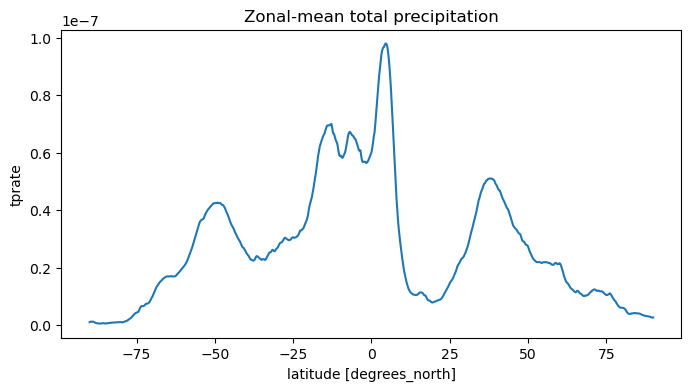

In [72]:
fig, ax = plt.subplots(figsize=(8,4), facecolor="white")
ds['tprate'].isel(time=0).mean('lon').plot(ax=ax)
plt.title('Zonal-mean total precipitation')

Text(0.5, 1.0, 'Hovmoeller plot of total precipitation')

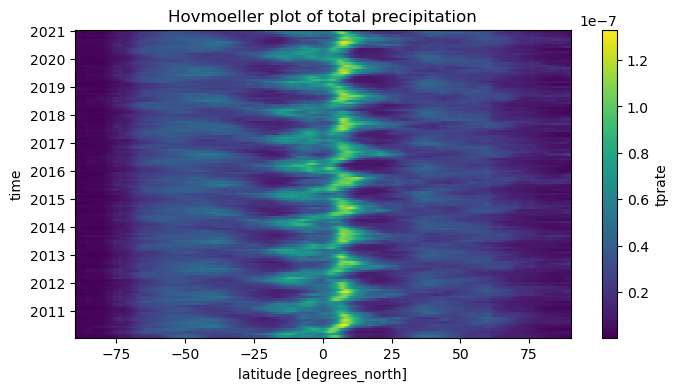

In [73]:
fig, ax = plt.subplots(figsize=(8,4), facecolor="white")
ds['tprate'].mean('lon').plot(ax=ax)
plt.title('Hovmoeller plot of total precipitation')

In [ ]:
ds['sst'].to_netcdf('sst.nc', mode='w') # write any path + filename here

## Now load the companion simulation with smoothed mesoscale SST anomalies and plot together

In [75]:
ds2 = ifs_to_latlon( # reshape to lat-lon grid
    ifs_fix_time_for_monthly_data( # fix time-axis for monthly
        cat['amip-hist-obs-lr30.atmos.gr025']['2D_monthly_0.25deg'].to_dask()
    )
)

(14610.0, 18627.0)

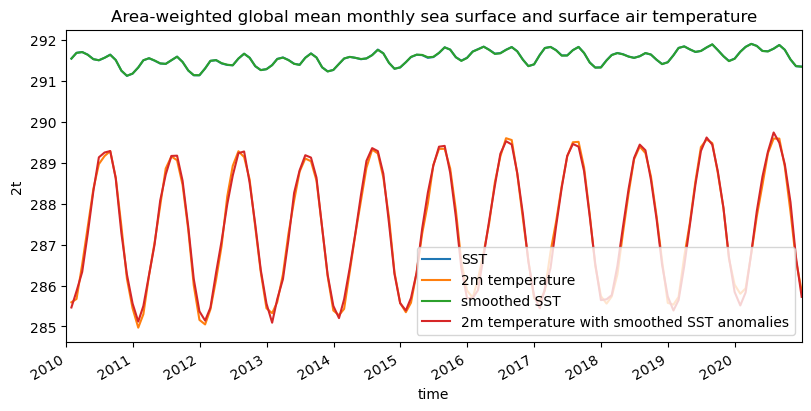

In [80]:
fig, ax = plt.subplots(figsize=(8,4),constrained_layout=True)

ds['sst'].weighted(area).mean(['lat','lon']).plot.line(
 '-',label='SST',ax=ax)
ds['2t'].weighted(area).mean(['lat','lon']).plot.line(
 '-',label='2m temperature',ax=ax)

ds2['sst'].weighted(area).mean(['lat','lon']).plot.line(
 '-',label='smoothed SST',ax=ax)
ds2['2t'].weighted(area).mean(['lat','lon']).plot.line(
 '-',label='2m temperature with smoothed SST anomalies',ax=ax)

ax.legend()
ax.set_title("Area-weighted global mean monthly sea surface and surface air temperature")

ax.set_xlim(
    datetime(2010,1,1),
    datetime(2020,12,31)
)

## => Note the identical global mean SST between the runs (smoothing does not affect the global mean) but the 2m temperature is different

## Work with high-frequency data

In [81]:
ds_2d_6h = ifs_to_latlon( # reshape to lat-lon grid
        cat['amip-hist-obs-lr30.atmos.gr025']['2D_6h_0.25deg'].to_dask()
)

#### Get whole dataset for one grid point

In [82]:
# the point we are interesting in (Madrid as example)
lon_target = 8.5809
lat_target = 53.5396

tp_point = ds_2d_6h.tp.sel(
    lon=lon_target,
    lat=lat_target,
    method='nearest')


In [83]:
tp_point

<xarray.DataArray 'tp' (time: 16073)>
dask.array<getitem, shape=(16073,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 53.5
    lon      float64 8.5
  * time     (time) datetime64[ns] 2010-01-01 2010-01-01T06:00:00 ... 2021-01-01
Attributes: (12/15)
    paramId:                    228
    dataType:                   fc
    numberOfPoints:             1038240
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    name:                       Total precipitation
    cfVarName:                  tp
    missingValue:               3.4028234663852886e+38
    totalNumber:                1
    NV:                         0
    gridDefinitionDescription:  Latitude/Longitude Grid

### Load the data - this takes a while because (see just above) the data is stored as one chunk per timestep - so all the globe needs to be loaded even though only one gridpoint is requested

In [85]:
with ProgressBar():
    tp_point.load()

[########################################] | 100% Completed | 141.64 s


In [89]:
tp_point

<xarray.DataArray 'tp' (time: 16073)>
array([0.00000000e+00, 1.88827515e-04, 9.53674316e-06, ...,
       2.76565552e-04, 4.69207764e-04, 5.76019287e-04])
Coordinates:
    lat      float64 53.5
    lon      float64 8.5
  * time     (time) datetime64[ns] 2010-01-01 2010-01-01T06:00:00 ... 2021-01-01
Attributes: (12/15)
    paramId:                    228
    dataType:                   fc
    numberOfPoints:             1038240
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    name:                       Total precipitation
    cfVarName:                  tp
    missingValue:               3.4028234663852886e+38
    totalNumber:                1
    NV:                         0
    gridDefinitionDescription:  Latitude/Longitude Grid

Step-wise precipitation output is saved as accumulated precipitation per time-interval, in this case 6 hours. So this data represented m/6hours. Let's convert to mm

In [91]:
tp_point = tp_point*1000
tp_point.attrs['units'] = 'mm'

In [111]:
# Quick stats using pandas:
tp_point.to_pandas().describe()

count    16073.000000
mean         0.629015
std          1.482610
min          0.000000
25%          0.000000
50%          0.041962
75%          0.494003
max         18.093109
dtype: float64

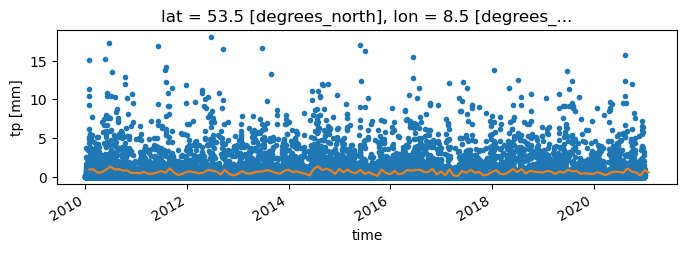

In [93]:
tp_point.plot.line(
    '.',
    figsize=(8,2)
)
tp_point.resample(time='1M').mean().plot()

### Make a histogram of 6-hourly precipitation

Text(0.5, 1.0, 'Histogram of 6-hourly precipitation at 53.5 N, 8.6 E')

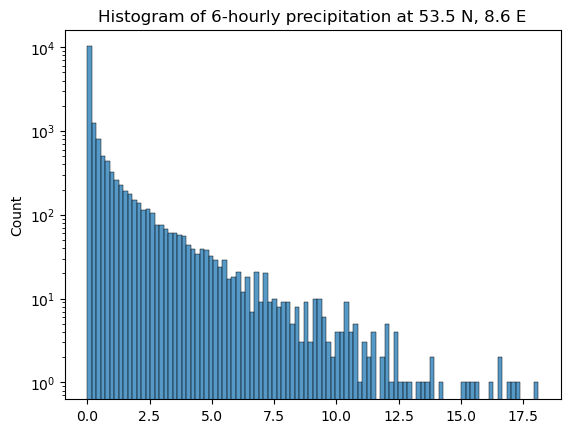

In [102]:
sns.histplot(
    tp_point,
    bins=100,
    log=True,
    # kde=True
)
plt.title('Histogram of 6-hourly precipitation at %.1f N, %.1f E' % (lat_target,lon_target))

In [124]:
# Get timestep with the highest precipitation:
tp_point_max_step = tp_point.to_pandas().sort_values().index[-1]#[[-1]].index.values

#### Get one timestep over Europe, and plot precipitation together with mean sea level pressure contours

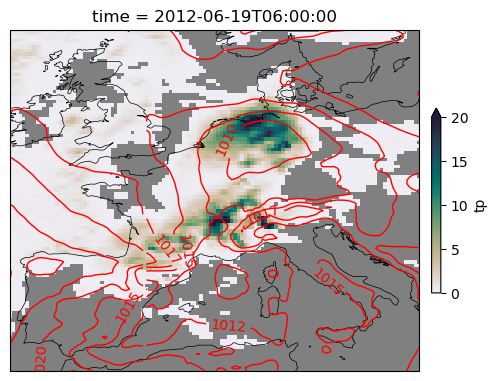

In [170]:
ff = (
    ds_2d_6h.tp.sel(time=tp_point_max_step) 
    * 1000
).where(
    lambda x:x>0 # mask points with no precipitation
).plot(
    subplot_kws=dict(
        projection=ccrs.PlateCarree()
    ),
    cbar_kwargs=dict(
        shrink=0.5,
        pad=0.025
    ),
    transform=ccrs.PlateCarree(),
    cmap=cmo.rain,
    vmin=0,
    vmax=20
)


p = (
    ds_2d_6h.msl.sel(time=tp_point_max_step).sel(lat=slice(30,80))
    / 100
).plot.contour(
    ax=ff.axes,
    levels=20,
    colors='r',
    linewidths=1,
    transform=ccrs.PlateCarree(),
)

ff.axes.set_facecolor('grey')
ff.axes.set_extent([-10,20,35,60],crs=ccrs.PlateCarree())
ff.axes.clabel(p,fmt='%i')


ff.axes.coastlines(lw=0.5)